In [ ]:
# 1. Framework Utama
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

# 2. Arsitektur Model Spesifik (ConvNeXt tersedia di Keras Applications)
from tensorflow.keras.applications import ConvNeXtTiny, ConvNeXtBase, ConvNeXtLarge

# 3. Manipulasi Data & File Sistem
import numpy as np
import os
import pathlib

# 4. Visualisasi & EDA
import matplotlib.pyplot as plt
import seaborn as sns

# 5. Evaluasi & Metrik
from sklearn.metrics import classification_report, confusion_matrix

import gc

2025-12-30 10:08:28.520769: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767089309.031827      25 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767089309.160510      25 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767089310.385003      25 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767089310.385034      25 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767089310.385037      25 computation_placer.cc:177] computation placer alr

In [ ]:
import os

# Start dari folder input paling luar
base_dir = '/kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_Diease/Rice_Leaf_Diease'

print(f"Isi folder {base_dir}:")
print(os.listdir(base_dir))

inner_dir = os.path.join(base_dir, 'Rice_Leaf_Diseases')
if os.path.exists(inner_dir):
    print(f"\nIsi folder {inner_dir}:")
    print(os.listdir(inner_dir))

📂 Isi folder /kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_Diease/Rice_Leaf_Diease:
['test', 'train']


In [ ]:
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Cek apakah path benar
if os.path.exists(train_dir) and os.path.exists(test_dir):
    print(f"Path ditemukan!")
    print(f"Train Path: {train_dir}")
    print(f"Test Path:  {test_dir}")
else:
    print("Path masih salah, cek lagi struktur folder di kanan.")

# --- 2. Load Train & Validation (Dari folder 'train') ---
batch_size = 32
img_size = (224, 224)

print("\n--- Loading Training & Validation ---")
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# --- Loading Test Data ---
print("\n--- Loading Test Data ---")
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

# --- 4. Cek Nama Kelas ---
class_names = train_ds.class_names
print(f"\nKelas ditemukan: {class_names}")

✅ Path ditemukan!
Train Path: /kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_Diease/Rice_Leaf_Diease/train
Test Path:  /kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_Diease/Rice_Leaf_Diease/test

--- Loading Training & Validation ---
Found 15023 files belonging to 10 classes.
Using 12019 files for training.


I0000 00:00:1767089349.101284      25 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767089349.105350      25 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 15023 files belonging to 10 classes.
Using 3004 files for validation.

--- Loading Test Data ---
Found 3422 files belonging to 10 classes.

Kelas ditemukan: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot', 'neck_blast', 'rice_hispa', 'sheath_blight', 'tungro']


# **OPTIMASI PEFORMA DATASET**

In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE

def configure_for_performance(ds, is_train=False):
  # ds = ds.cache () #simpan data di RAM setelah E1

  if is_train:
    ds = ds.shuffle(1000)

  ds = ds.prefetch(buffer_size=2)
  return ds

train_ds = configure_for_performance(train_ds, is_train=True)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

# **AUGMENTASI DATA & BANGUN MODEL**

In [ ]:
from tensorflow.keras import mixed_precision

# Set policy ke mixed_float16
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ConvNeXtBase

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.05)
], name="data_augmentation")

base_model = ConvNeXtBase(
    include_top=False,
    weights = 'imagenet',
    input_shape=(224, 224, 3)
)

base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False) # training=False: Menjaga BatchNormalization tetap dalam mode inference

x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(len(class_names), activation='softmax', dtype='float32')(x)

model = tf.keras.Model(inputs, outputs, name = "ConvNeXtBase_RiceDisease")

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "ConvNeXtBase_RiceDisease"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_base (Functional)      │ (None, 7, 7, 1024)     │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,835,530 (335.07 MB)

 Trainable params: 267,018 (1.02 MB)

 Non-trainable params: 87,568,512 (334.05 MB)

# **CALLBACKS**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Tentukan nama file penyimpanan model
# Gunakan format .keras (format baru TensorFlow) atau .h5
filepath = 'best_rice_model.keras'

class ClearMemory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect() # Paksa buang sampah memori
        tf.keras.backend.clear_session() # Bersihkan state backend keras

callbacks_list = [
    # 1. ModelCheckpoint: Simpan model terbaik berdasarkan Val Accuracy
    ModelCheckpoint(
        filepath=filepath,
        monitor='val_accuracy', # Yang dipantau adalah akurasi validasi
        save_best_only=True,    # Hanya simpan jika akurasi MEMECAHKAN REKOR tertinggi
        mode='max',             # Kita cari nilai max (karena akurasi)
        verbose=1
    ),

    # 2. EarlyStopping: Berhenti jika Val Loss tidak turun-turun
    EarlyStopping(
        monitor='val_loss',     # Pantau error validasi
        patience=5,             # Tunggu 5 epoch. Kalau 5x berturut-turut ga membaik, STOP.
        restore_best_weights=True, # Kembalikan bobot ke kondisi terbaik (bukan kondisi terakhir)
        verbose=1
    ),

    # 3. ReduceLROnPlateau: Kecilkan Learning Rate jika mentok
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,             # Kurangi LR sebesar 50% (dikali 0.5)
        patience=3,             # Jika 3 epoch ga ada perbaikan, turunkan LR
        min_lr=1e-6,            # Batas bawah LR
        verbose=1
    ),

    ClearMemory()
]

# **TRAINING DATA**

In [ ]:
# Mulai Training
print("Training dimulai... (Bisa ditinggal ngopi ☕)")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,  # Set tinggi saja, EarlyStopping akan menghentikannya jika perlu
    callbacks=callbacks_list,
    verbose=1
)

print("Training selesai!")

Training dimulai... (Bisa ditinggal ngopi ☕)
Epoch 1/50


I0000 00:00:1767089461.172676      75 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1767089462.835934      75 service.cc:152] XLA service 0x7a911b45b1b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767089462.835970      75 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1767089462.835974      75 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1767089467.481244      75 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.4690 - loss: 1.6711
Epoch 1: val_accuracy improved from -inf to 0.80493, saving model to best_rice_model.keras
376/376 ━━━━━━━━━━━━━━━━━━━━ 488s 876ms/step - accuracy: 0.4694 - loss: 1.6698 - val_accuracy: 0.8049 - val_loss: 0.6229 - learning_rate: 1.0000e-04
Epoch 2/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.7762 - loss: 0.6798
Epoch 2: val_accuracy improved from 0.80493 to 0.85220, saving model to best_rice_model.keras
376/376 ━━━━━━━━━━━━━━━━━━━━ 211s 430ms/step - accuracy: 0.7763 - loss: 0.6796 - val_accuracy: 0.8522 - val_loss: 0.4389 - learning_rate: 1.0000e-04
Epoch 3/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.8327 - loss: 0.4976
Epoch 3: val_accuracy improved from 0.85220 to 0.88083, saving model to best_rice_model.keras
376/376 ━━━━━━━━━━━━━━━━━━━━ 212s 430ms/step - accuracy: 0.8327 - loss: 0.4975 - val_accuracy: 0.8808 - val_loss: 0.3536 - learning_rate: 1.0000e-04
Epoch 4/50
376/376 ━━

# **VISUALISASI HASIL**

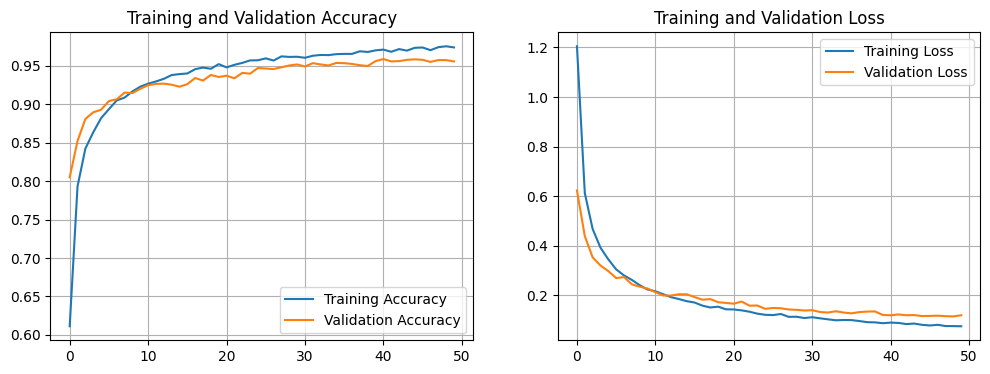

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))

    # Plot Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.grid(True)

    plt.show()

# Panggil fungsinya
plot_history(history)